# Intel MPI Benchmarks

Results of selected MPI1 tests from the [IMB benchmark suite](https://software.intel.com/content/www/us/en/develop/documentation/imb-user-guide/top.html).

All tests use two nodes:
- pingpong: Single process per node
- uniband: Multiple processes per node, communicating in pairs split across nodes
- biband: As for uniband but communication initiated in both directions
- alltoall: As many processes on each node as there are (hardware) cores

Tests use a range of message sizes and report bandwidth and/or latency.

In [4]:
# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import display, HTML

import pandas as pd
import os, sys
from pprint import pprint
sys.path.extend(('../../reframe', '../../')) # the `modules` package imports `reframe` so need that in sys.modules
import modules

# Bandwidth/latency vs message size

The plots below show results vs message size for selected tests:
- pingpong
- 2x process runs of uniband and biband
- alltoall (using all cores on each node)

Results are for the most-recent test on each system/partition/environment combination.

IndexError: list index out of range

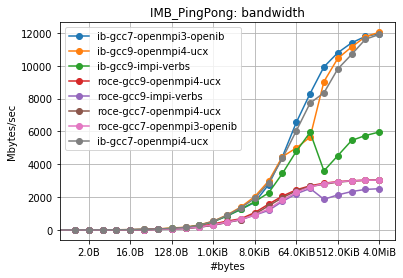

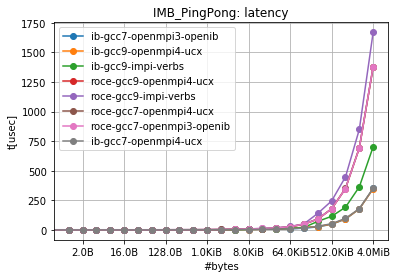

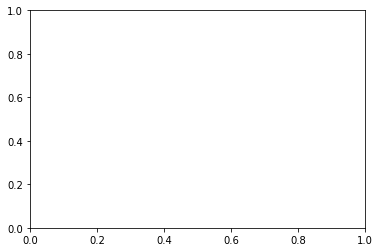

In [14]:
for (test, column, param) in [('IMB_PingPong', 'Mbytes/sec', 'bandwidth'),
                              ('IMB_PingPong', 't[usec]', 'latency'),
                              ('IMB_Biband_2', 'Mbytes/sec', 'bandwidth'),
                              ('IMB_Uniband_2', 'Mbytes/sec', 'bandwidth'),
                             ]:
    
    # find all data and work out differences between them:
    paths = modules.utils.find_run_outputs(root='../../output', test=test)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    common, meta_diffs = modules.utils.diff_dicts([modules.utils.parse_path_metadata(p) for p in paths], ignore=['path'])
    
    # load and plot:
    for ix, path in enumerate(paths):
        datas = modules.imb.read_imb_out(path)
        assert len(datas) == 1
        data = datas[list(datas.keys())[0]]
        label = '-'.join(meta_diffs[ix].values())
        plt.plot(data['#bytes'], data[column], 'o-', data=data, label=label)
        
    # format plot:
    ax.set_xscale('log', basex=2)
    #ax.set_yscale('log', basey=10)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: modules.utils.sizeof_fmt(x)))
    ax.grid(True, which="both")
    ax.set_xlabel('#bytes')
    ax.set_ylabel(column)
    ax.set_title('%s: %s' % (test, param))
    ax.legend()

# Max Bandwidth vs Number of Processes per Node

The plots below show the **maximum** bandwidth for tests using varying numbers of processes per node. Results are for the most-recent test on each system/partition/environment combination.


IMB_Uniband_*: max_bandwidth (Mbytes/sec)


case,alaska-ib-gcc9-impi-verbs-imb,alaska-ib-openmpi3-openib-imb,alaska-ib-openmpi4-ucx-imb,alaska-roce-gcc9-impi-verbs-imb,alaska-roce-openmpi3-openib-imb,alaska-roce-openmpi4-ucx-imb
procs_per_node,,,,,,
1,NaN,12089.65,12357.77,NaN,3061.16,3062.64
2,10966.33,12049.31,12337.23,3028.83,3061.21,3060.69
4,11879.23,12260.41,12323.04,3050.95,3062.13,3063.04
8,12192.57,12358.03,12255.65,3058.15,3060.86,3059.09
16,12317.34,12072.82,12351.21,3060.26,3063.13,3063.48
32,12060.42,12390.58,12386.86,3061.55,3063.44,3063.54
64,12379.77,12392.76,13240.71,3061.62,3063.45,3063.49


Max bandwidth (any # procs): % of theoretical bandwidth
-----------------------------------------
alaska-ib-gcc9-impi-verbs-imb: 99%
alaska-ib-openmpi3-openib-imb: 99.1%
alaska-ib-openmpi4-ucx-imb: 106%
alaska-roce-gcc9-impi-verbs-imb: 98%
alaska-roce-openmpi3-openib-imb: 98%
alaska-roce-openmpi4-ucx-imb: 98%

IMB_Biband_*: max_bandwidth (Mbytes/sec)


case,alaska-ib-gcc9-impi-verbs-imb,alaska-ib-openmpi4-ucx-imb,alaska-roce-gcc9-impi-verbs-imb,alaska-roce-openmpi3-openib-imb,alaska-roce-openmpi4-ucx-imb
procs_per_node,,,,,
1,NaN,20820.42,NaN,6112.92,6117.19
2,13471.09,20888.13,5963.44,6121.51,6114.86
4,11459.07,20644.45,6034.67,6117.81,6119.70
8,19520.43,20308.28,6092.23,6120.44,6122.13
16,20434.49,20818.45,6113.04,6125.08,6122.36
32,20682.17,20906.88,6116.30,6126.41,6125.93
64,20739.54,20555.39,6117.78,6126.48,6126.57


Max bandwidth (any # procs): % of theoretical bandwidth
-----------------------------------------
alaska-ib-gcc9-impi-verbs-imb: 83%
alaska-ib-openmpi4-ucx-imb: 83.6%
alaska-roce-gcc9-impi-verbs-imb: 97.9%
alaska-roce-openmpi3-openib-imb: 98%
alaska-roce-openmpi4-ucx-imb: 98%


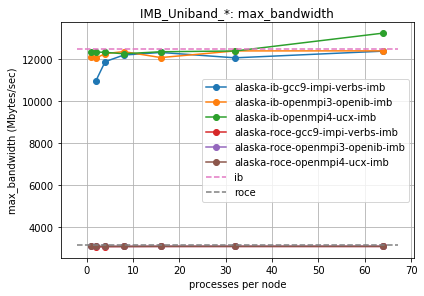

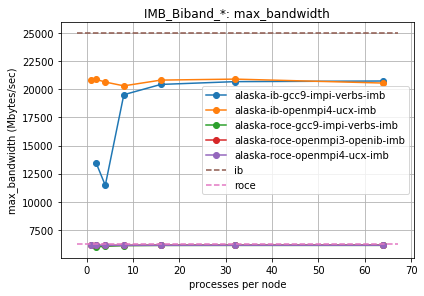

In [29]:
# TODO: needs to be loaded from system config somewhere
Gb_to_MB = 125.0
ALASKA_BANDWIDTH = {'ib': 100 * 125.0, 'roce': 25 * Gb_to_MB}

for test in ['IMB_Uniband_*', 'IMB_Biband_*']:
    
    test_bandwidth_factor = {'IMB_Uniband_*':1.0, 'IMB_Biband_*':2.0}[test] # b/c biband is bidirectional
    
    # load perf records:
    perf_records = modules.utils.load_perf_logs('../perflogs', test, '.log')
    
    # calculate number of processes (=tasks):
    perf_records['procs_per_node'] = [int(tn.rsplit('_')[-1]) for tn in perf_records['testname']]
    
    # plot/tabulate:
    for perf_var in ['max_bandwidth']:
        perf_unit = perf_records[perf_records['perf_var'] == perf_var]['perf_unit'].iloc[0] # assumes unique
        table = modules.plots.tabulate_last_perf_vs(perf_records, 'procs_per_node', perf_var)
        
        ax = table.plot(grid=True, style='o-')
        
        xlim = ax.get_xlim()
        for net, bwidth in ALASKA_BANDWIDTH.items():
            bw = bwidth * test_bandwidth_factor
            ax.plot(xlim, [bw, bw], '--', label=net)
        
        ax.set_xlabel('processes per node')
        ax.set_ylabel('%s (%s)' % (perf_var, perf_unit))
        plt.tight_layout()
        ax.set_title('%s: %s' % (test, perf_var))
        ax.legend()
        
        print()
        print('%s: %s (%s)' % (test, perf_var, perf_unit))
        display(HTML(table.to_html()))
        
        # calculate real vs theortical perf, for highest bandwidth in each system/partition/environment:
        # TODO: needs sorting properly and generalising
        print('Max bandwidth (any # procs): % of theoretical bandwidth')
        print('-----------------------------------------')
        
        
        max_for_spe = table.max(0).to_dict()
        for partition, max_val in max_for_spe.items():
            for net in ALASKA_BANDWIDTH:
                if '-%s-' % net in partition:
                    efficiency = 100 * max_val / (ALASKA_BANDWIDTH[net] * test_bandwidth_factor)
                    print('%s: %.3g%%' % (partition, efficiency))
        
        
